In [1]:
import torch
import os
#from ch7.weather.model.model import TcnClassifier
#from ch7.weather.utils import sliding_window
import pandas as pd
import numpy as np
import random
import copy

raw_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQwC6jRtVUk-2dkk2W3BDJZTOdsS427LN8Ixo-rQF4Afs6ice0rof7qh_EbnAy5lYEGqX-TCSvjpPyr/pub?gid=1713335339&single=true&output=csv',
                        index_col=['codigo','Tiempo']).drop(['Fecha','Exposicion'], axis=1)

features_cont      = raw_df.columns.tolist()
#imputed_train_df   = abs(pd.read_csv('imputed_train_df.csv', index_col=['codigo']).drop('Unnamed: 0', axis=1))#.sort_index(inplace=False))
#imputed_val_df     = abs(pd.read_csv('imputed_val_df.csv', index_col=['codigo']).drop('Unnamed: 0', axis=1))#.sort_index(inplace=False))



imputed_df =  abs(pd.read_csv('all_data_imputed.csv', index_col=['codigo']))#.sort_index(inplace=False))



/DeepenData/.miniconda/envs/torch_aa/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


#imputed_df         = pd.concat([imputed_val_df, imputed_train_df])#.sort_index(inplace=False)
codigos            = imputed_df.index.get_level_values('codigo').unique().tolist()
imputed_df.columns = raw_df.columns.tolist()
imputed_df['alfafeto_bad'] = np.where((imputed_df['Alfa-fetoprot'] > 10), 'Yes', 'No')

features_cont      = imputed_df.select_dtypes(float).columns.tolist()
features_cat = ['alfafeto_bad']

In [3]:
df = copy.deepcopy(imputed_df)

from ch7.weather.utils import sliding_window
w = 3
X, Y = [], []
for l in codigos:
    df_l = df.loc[l]
    D = []
    for f in features_cont:
        D.append(df_l[f].interpolate('linear').fillna(0).values)
    for f in features_cat:
        D.append(df_l[f].map({'Yes': 1, 'No': 0}).fillna(0).values)
        # transpose to time series
    TS = []
    for i in range(df_l.shape[0]):
        row = []
        for c in D:
            row.append(c[i])
        TS.append(row)
    in_seq, out_seq = sliding_window(TS, w, 1)
    rain_seq = [r[0][-1] for r in out_seq]
    X.extend(in_seq)
    Y.extend(rain_seq)

# Train-Validation Split
X_train, Y_train = [], []
X_val, Y_val = [], []
for i in range(len(X)):
    if random.random() > .8:
        X_val.append(X[i])
        Y_val.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])

x_train = torch.tensor(X_train).float().transpose(1, 2)

params = {"tcl_num":          4,
        "tcl_channel_size": 25,
        "kernel_size":      4,
        "dropout":          0.1,
        "slices":           1,
        "use_bias":         True,
        "lr":                0.03388437885302203}
tcl_num = params['tcl_num']
tcl_channel_size = params['tcl_channel_size']
# temporal casual layer channels
channel_sizes = [tcl_channel_size] * tcl_num
# convolution kernel size
kernel_size = params['kernel_size']
dropout = params['dropout']
slices = params['slices']
use_bias = params['use_bias']
lr = params['lr']
model_params = {
    'num_inputs':   len(features_cont) + len(features_cat),
    'num_classes':  2,
    'num_channels': channel_sizes,
    'kernel_size':  kernel_size,
    'dropout':      dropout,
    'slices':       slices,
    'act':          'relu',
    'use_bias':     use_bias
}
from ch7.weather.model.model import TcnClassifier

model = TcnClassifier(**model_params)


print(x_train.shape)

prediction = model(x_train)

print(prediction.shape)

torch.Size([92, 52, 3])
torch.Size([92, 2])


In [4]:
def sliding_window(ts, features,Y_idx, target_len = 1):
    X, Y = [], []
    for i in range(features + target_len, ts.shape[0] + 1):  #
        
        
        X.append(ts[i - (features + target_len):i - target_len,:]) #
        Y.append(ts[i - target_len:i, Y_idx]) #
        
    return  X,  Y




X_seq, Y_seq = sliding_window(np.array(df.loc['T15']), w, np.where(df.columns == 'alfafeto_bad')[0][0])

np.array(X_seq).shape

(6, 3, 52)

In [5]:

def get_one_patient_windows(a_patient, target_var, window_length, target_length = 1):
    patient_followup      = df.loc[a_patient]
    patient_target_var    = patient_followup.pop(target_var)
    sequence_length       = patient_followup.shape[0]
    window_plus_target    = window_length + target_length
    X = list()
    y = list()
    for i, time_point in enumerate(range(window_plus_target, sequence_length + 1)):
        X_multivar_window = patient_followup.iloc[(time_point - window_plus_target) : (time_point - target_length), :]
        Y_target          = patient_target_var.iloc[(time_point - target_length) : time_point].map({'Yes': 1, 'No': 0})
        X.append(torch.tensor(X_multivar_window.to_numpy()))
        y.append(torch.tensor(Y_target.to_list()))
                
    patient_windows = torch.cat(X).reshape(i+1,window_length,51)
    patient_target  = torch.cat(y)
    return patient_windows, patient_target

patient_windows, patient_target = get_one_patient_windows('T15', 'alfafeto_bad', 3)

In [6]:

from torch.utils.data import Dataset, DataLoader, RandomSampler

class patients_batch(Dataset):
    def __init__(self, codigos, target_var, window_length):
        super(patients_batch, self).__init__()
        self.codigos       = codigos
        self.target_var    = target_var
        self.window_length = window_length
        
    def __len__(self):
        return len(self.codigos)
    
    def __getitem__(self, index):
        one_patient_X, one_patient_y = get_one_patient_windows(self.codigos[index], self.target_var, self.window_length)      
        return one_patient_X, one_patient_y
    
    
batch_dataset = patients_batch(codigos, 'alfafeto_bad', 3)
batch_loader  = DataLoader(batch_dataset, batch_size=3)



X_batch, y_batch = next(iter(batch_loader))

X_batch_reshaped = X_batch.reshape(X_batch.shape[0]*X_batch.shape[1],3,51).transpose(1,2).float()#.shape #.shape, y_batch.flatten().shape
y_batch_reshaped = y_batch.flatten().long()

In [7]:
params = {"tcl_num":          4,
        "tcl_channel_size": 25,
        "kernel_size":      4,
        "dropout":          0.1,
        "slices":           1,
        "use_bias":         True,
        "lr":                0.03388437885302203}
tcl_num = params['tcl_num']
tcl_channel_size = params['tcl_channel_size']
# temporal casual layer channels
channel_sizes = [tcl_channel_size] * tcl_num
# convolution kernel size
kernel_size = params['kernel_size']
dropout = params['dropout']
slices = params['slices']
use_bias = params['use_bias']
lr = params['lr']
model_params = {
    'num_inputs':   len(features_cont),# + len(features_cat),
    'num_classes':  2,
    'num_channels': channel_sizes,
    'kernel_size':  kernel_size,
    'dropout':      dropout,
    'slices':       slices,
    'act':          'relu',
    'use_bias':     use_bias
}

model_params['num_inputs']


51

In [8]:
model = TcnClassifier(**model_params)

optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
cl_loss = torch.nn.CrossEntropyLoss()


training_loss = []
epochs        = 100
for _ in range(epochs):
    
    for X_batch, y_batch in batch_loader:

        X_batch_reshaped = X_batch.reshape(X_batch.shape[0]*X_batch.shape[1],3,51).transpose(1,2).float()#.shape #.shape, y_batch.flatten().shape
        y_batch_reshaped = y_batch.flatten().long()
        
        
        prediction = model(X_batch_reshaped)
        loss       = cl_loss(prediction, y_batch_reshaped)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item()) 
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


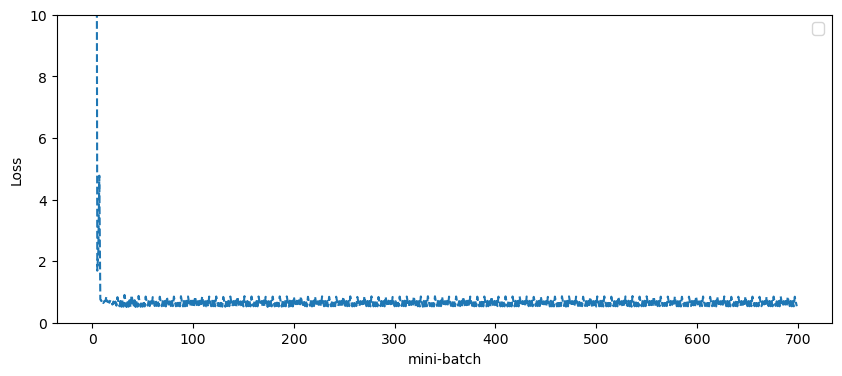

In [9]:
import matplotlib.pyplot as plt
def put_Learning_curve(loss1, AX, letter):
    AX.plot(loss1,  label = "", linestyle="--")
    #AX.plot(loss2,  label = "imputation_loss", linestyle="-")
    #AX.plot(loss3,  label = "total_loss", linestyle="--")
    
    
    
    AX.legend(loc="upper right", fontsize=11)
    AX.set_ylabel('Loss')
    AX.set_xlabel("mini-batch")
    AX.set_ylim(0, 10)
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')

fig = plt.figure(figsize=(10,4))
ax0 = plt.subplot2grid((1, 1), (0, 0))
put_Learning_curve(training_loss, 
                   ax0, '')

In [10]:

from sklearn.metrics import roc_curve, auc

tprs            = []
aucs = []
base_fpr = np.linspace(0, 1, 101)
for i, (X_batch, y_batch) in enumerate(batch_loader):
    X_batch_reshaped = X_batch.reshape(X_batch.shape[0]*X_batch.shape[1],3,51).transpose(1,2).float()#.shape #.shape, y_batch.flatten().shape
    y_batch_reshaped = y_batch.flatten().long()
                               

    prediction = model(X_batch_reshaped)    
    pred            = prediction.argmax(dim=1)
    y_pred_tag      = pred.squeeze().cpu().int().tolist()
    y_true     = y_batch_reshaped.squeeze().cpu().int().tolist()
    fpr, tpr, _ = roc_curve(y_true, y_pred_tag)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)


tprs      = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
mean_auc  = auc(base_fpr, mean_tprs)
std_auc   = np.std(aucs)


tprs_upper = np.minimum(mean_tprs + tprs.std(axis=0), 1)
tprs_lower = mean_tprs - tprs.std(axis=0)


   

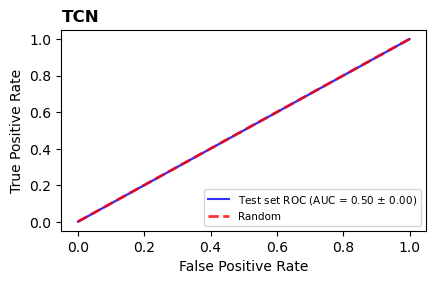

In [11]:
def put_ROC_in_subplot(base_fpr, mean_tprs, tprs_lower,
                   tprs_upper, mean_auc, std_auc, AX, xlabel:str='', letter:str=''):
    
    AX.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Test set ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    AX.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
    AX.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Random', alpha= 0.8)

    #ax1.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])

    AX.legend(loc="lower right", fontsize=7.5)
    AX.set_ylabel('True Positive Rate')
    AX.set_xlabel(xlabel)
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=1)
#ax1 = plt.subplot2grid((4, 3), (1, 0), colspan=1) 
put_ROC_in_subplot(base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc,
                   ax1, xlabel = 'False Positive Rate', letter = 'TCN')
